딥러닝 파이토치 교과서 ch5.3 p.200~229

### **[개념 정리+코드 필사]📝**

### **5.3 전이 학습**

합성곱 신경망 기반 딥러닝 모델 훈련시키려면 큰 데이터 셋이 필요 --> 구하기 어려운 문제를 전이 학습으로 해결
- 전이 학습: 아주 큰 데이터셋으로 사전훈련된 모델(네트워크)의 가중치를 가져와 보정해서 우리 과제에 사용하는 것
  - 적은 수의 데이터로도 과제 해결 가능
  - 방법: 특성 추출 / 미세 조정 기법
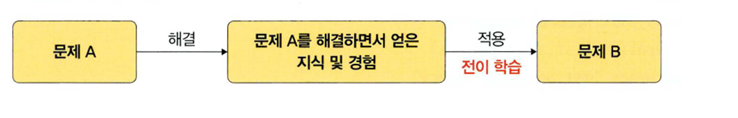



5.3.1 특성 추출 기법

- ImageNet데이터셋으로 사전 훈련된 모델을 가져와 마지막의 완전연결층 부분만 새로 만드는 방법. 즉, 마지막 완전연결층만 학습함
  - 특성 추출은 합성곱층(합성곱층+풀링층) + 완전연결층(데이터 분류기-특성 입력받아 최종 이미지 클래스 분류)
- 새로운 데이터 -> 사전훈련 네트워크의 합성곱층 -> 완전연결층에서 훈련
  - 사용가능한 이미지 분류모델: Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet
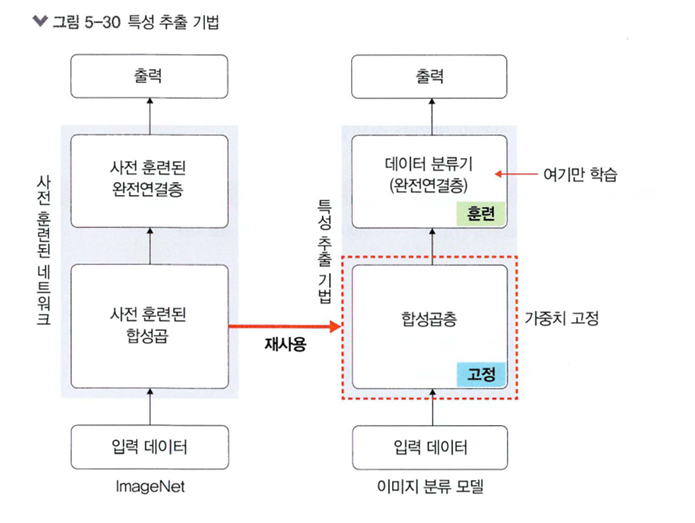

- OpenCV 라이브러리 설치: 오픈 소스 컴퓨터 비전 라이브러리
- 코드(13): 사용할 이미지 데이터에 대한 전처리 정의
  - torchvision.transform: 이미지 데이터 변환하여 모델의 입력으로 사용하게 함
    - Resize(전처리-이미지 조정 크기), RandomResizedCrop(데이터 확장-이미지를 랜덤한 크기 및 비율로 자름),  RandomHorizontalFlip(이미지 랜덤하게 수평으로 뒤집음), ToTensor(이미지를 텐서로 변환)

  - datasets.ImageFolder:데이터로더가 데이터를 불러올 대상과 방법을 정의
    - 데이터 위치 경로, transform(이미지 데이터 전처리)
  - torch.utils.dada.DataLoader(): 데이터 불러옴
    - 데이터셋 지정, batch_size, num_workers(사용할 하위 프로세스 개수), shuffle(무작위로 섞을건지 지정)
- RandomResizedCrop 🔽


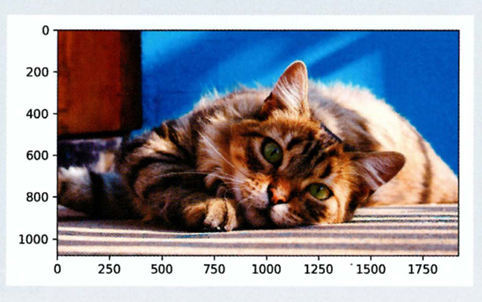

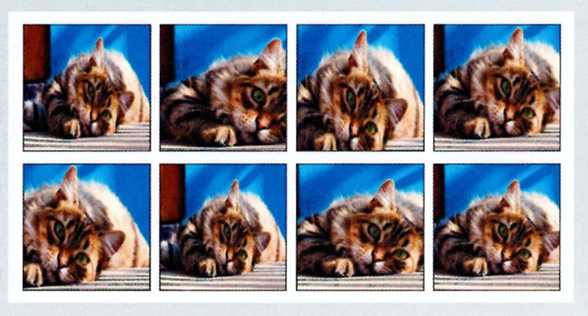

In [1]:
!pip install opencv-python

In [2]:
# 코드 12
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
# 코드 13. 이미지 데이터 전처리 방법 정의
data_path = '/content/drive/MyDrive/ESAA/OB 과제/catanddog/train'
transform = transforms.Compose(
    [transforms.Resize([256,256]),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


- 코드(14): 불러온 이미지 데이터에 대해 레이블 정보와 함께 출력
  - 반복자 사용- iter(): 전달된 데이터의 반복자를 꺼내 반환, next(): 반복자가 그 다음에 출력해야할 요소를 반환
- 코드(15): 사전 훈련된 ResNet18모델 내려받기
  - pretrained=True: 사전 훈련 가중치 사용
  - ResNet18: 50개 계층으로 구성된 합성곱 신경망
- 코드(16): 내려받은 ResNet18의 합성곱층을 사용하되 파라미터는 학습하지 않도록 고정
  - params.requires_grad=False: 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음. 모델 일부(합성곱층+풀링층) 고정하고 나머지 학습하고자 함

- 코드(17): 내려받은 ResNet18의 마지막 부분에 완전 연결층 추가. 완전연결층은 개와 고양이 클래스 분류
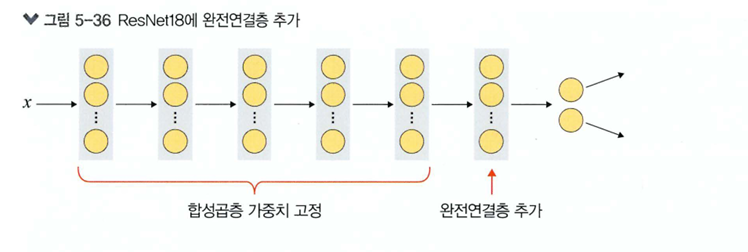


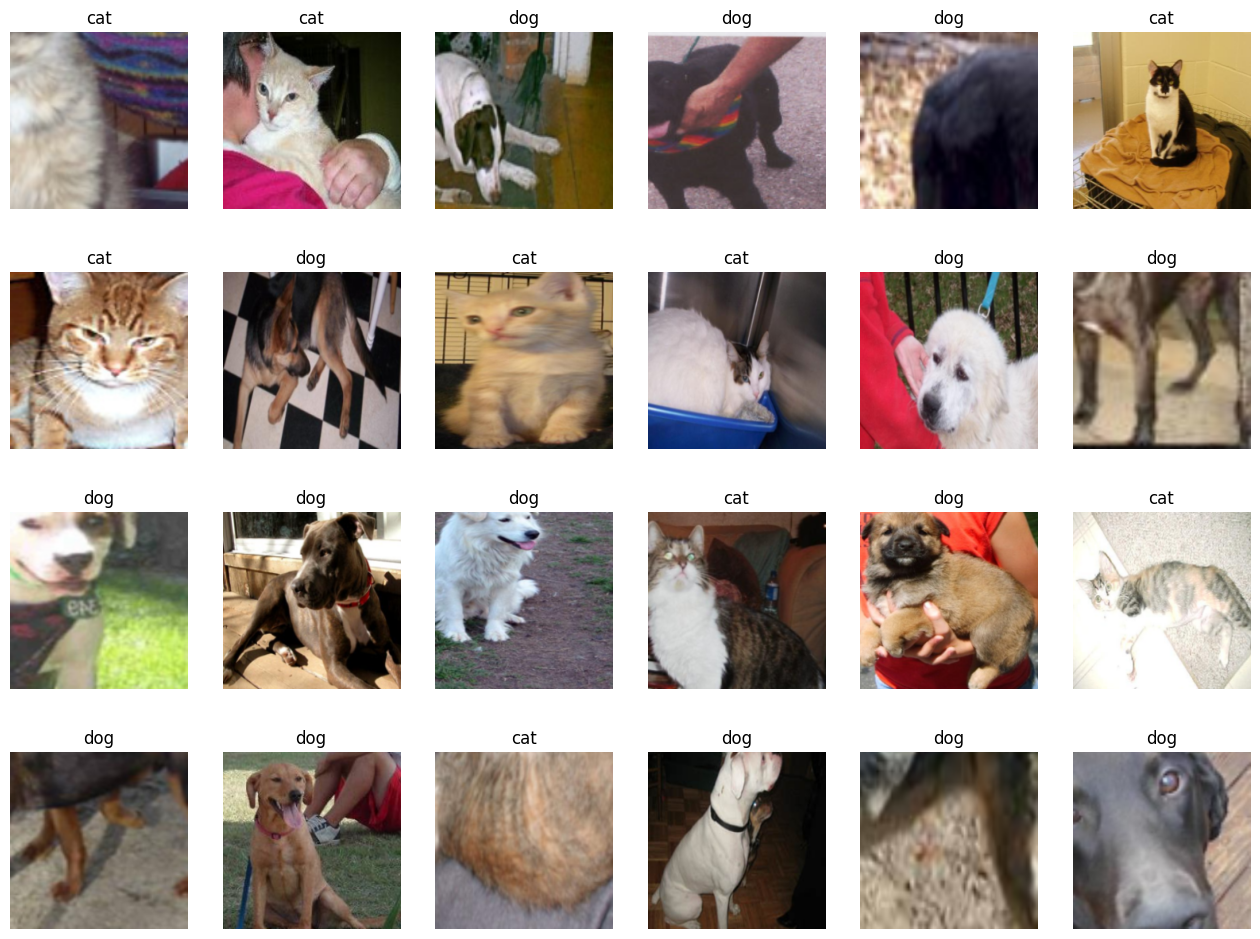

In [4]:
# 코드 14. 학습에 사용될 사용될 이미지 출력
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [5]:
# 코드 15. 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# 코드 16. 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [7]:
# 코드 17. ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

- 코드(18): 모델의 파라미터 값들 확인-weight, bias
- 코드(19): 모델 학습 준비 위해 모델의 객체 생성하고 손실함수 정의
  - 모델의 합성곱층 가중치 고정, 완전연결층은 학습
  - torch.nn.CrossEntropyLoss() 손실함수 정의
- 코드(20): 모델학습을 위한 함수 생성
  - num_epochs 만큼 반복
  - 데이터로더에 전달된 데이터만큼 반복
  - 출력 결과와 레이블 오차를 계산한 결과를 running_loss에 누적해 저장
  - 평균 오차와 평균 정확도 계산
  - 모델 재사용 위해 저장
  - 모델의 정확도와 오차, 실행시간 반환
- 코드(21): ResNet18에 추가된 완전연결층이 학습 -> 학습으로 얻어진 파라미터를 옵티마이저에 전달해 최종 모델학습에 사용
  - fc.weight, fc.bias 값들 업데이트되고 옵티마이저에 전달
- 코드(22): 모델 학습
  - 파라미터(모델, 학습 데이터, 손실 함수, 옵티마이저, 장치(CPU, GPU))
  - 학습 결과: 93%의 정확도.
  - 훈련 데이터로는 학습이 잘됨. 테스트 데이터로도 정확도 측정해야함

In [8]:
# 코드 18. 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0339,  0.0205, -0.0019,  ..., -0.0063,  0.0102, -0.0282],
        [-0.0400,  0.0226,  0.0437,  ...,  0.0119, -0.0067,  0.0253]])
fc.bias tensor([-0.0024,  0.0302])


In [9]:
# 코드 19. 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 코드 20. 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/ESAA/OB 과제/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [11]:
# 코드 21. 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [12]:
# 코드 22. 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5673 Acc: 0.6987

Epoch 1/12
----------
Loss: 0.4370 Acc: 0.7974

Epoch 2/12
----------
Loss: 0.3809 Acc: 0.8416

Epoch 3/12
----------
Loss: 0.2780 Acc: 0.9117

Epoch 4/12
----------
Loss: 0.2728 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.2607 Acc: 0.8857

Epoch 6/12
----------
Loss: 0.2729 Acc: 0.8883

Epoch 7/12
----------
Loss: 0.2091 Acc: 0.9325

Epoch 8/12
----------
Loss: 0.2320 Acc: 0.9039

Epoch 9/12
----------
Loss: 0.2479 Acc: 0.8883

Epoch 10/12
----------
Loss: 0.3227 Acc: 0.8494

Epoch 11/12
----------
Loss: 0.2461 Acc: 0.8831

Epoch 12/12
----------
Loss: 0.2020 Acc: 0.9117

Training complete in 11m 11s
Best Acc: 0.932468


- 코드(23): 테스트 데이터 불러와 전처리
  - 마찬가지로 transform 정의
  - 테스트 데이터가 98건으로 부족하지만 환경을 고려해 일부만 사용
- 코드(24): 테스트 데이터 평가를 위한 함수 생성
  - glob: 현재 디렉터리에서 원하는 파일들만 추출해 가져올 때 사용.
  glob.glob('/content/drive/MyDrive/ESAA/OB 과제/catanddog/' + '*.pth'): pth 확장자를 같는 파일(훈련 시 생성된 파일) 가져오기
  - torch.max: 최댓값이 들어있는 텐서 배열의 인덱스 반환
  - pred.eq(labels): preds 배열과 labels가 일치하는지 검사. sum(): 모델의 예측 결과와 정답이 일치하는 것들의 개수 합을 숫자로 출력

- 코드(25): 모델 평가함수에 테스트 데이터 적용해 실제 성능 측정
  - 94%의 높은 정확도
  - 사전 훈련 모델을 사용한다면 직접 네트워크 구현/최적 파라미터 값 찾지 않고 손쉽게 모델 학습 가능
- 코드(26): 모델의 학습 결과 시작적 확인(훈련, 테스트 데이터 정확도)
  - 훈련과 테스트 데이터에 대해 에포크가 진행될 때마자 정확도를 출력한 결과'
  - 에포크가 진행될수록 정확도가 100%에 수렴함
- 코드(27): 훈련 데이터의 오차정보 그래프 확인
  - 훈련 데이터에 대해 에포크마다 오차 출력한 결과
  - 에포크 진행될수록 오차가 낮아짐-> 학습 잘됨



In [20]:
# 코드 23. 테스트 데이터 호출 및 전처리
test_path = '/content/drive/MyDrive/ESAA/OB 과제/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [21]:
# 코드 24. 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/ESAA/OB 과제/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [22]:
# 코드 25. 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/ESAA/OB 과제/catanddog/00.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/01.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/02.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/03.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/04.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/05.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/06.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/07.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/08.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/09.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/10.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/11.pth', '/content/drive/MyDrive/ESAA/OB 과제/catanddog/12.pth']
Loading model /content/drive/MyDrive/ESAA/OB 과제/catanddog/00.pth
Acc: 0.8980

Loading model /content/drive/MyDrive/ESAA/OB 과제/catanddog/01.pth
Acc: 0.8571

Loading model /content/drive/MyDrive/ESAA/OB 과제/catanddog/02.pth
Acc: 0.9490

Loading model /cont

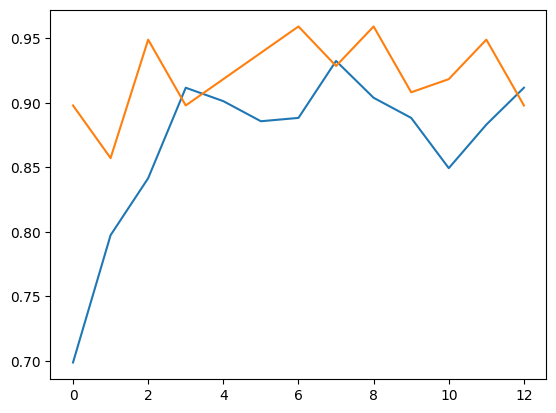

In [23]:
# 코드 26. 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

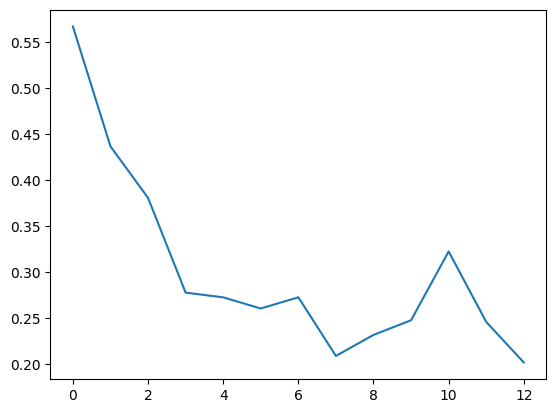

In [24]:
# 코드 27. 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

- 코드(28): 실제 데이터를 잘 예측하는지 확인
  - 예측 이미지 출력 위해 전처리 함수 생성
  - tensor.clone(): 기존 텐서의 내용을 복사한 텐서 생성  + detach(): 기존 텐서에서 기울기가 전파되지 않는 텐서 = tensor.clone().detach(): 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지는 않음
  - clip(): 입력값이 주어진 범위를 벗어날 때 특정 범위로 제한
    - image.clip(0,1): image데이터를 0,1 사이로 제한
- 코드(29): 테스트 데이터셋을 이용해 실제 개와 고양이 잘 분류하는지 예측 결과 확인
  - add_subplot: 한 화면에 여러 이미지 담기 위함
  - classes[preds[idx].item()] = 0이면 고양이, 1이면 개로출력
  - plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0): 서브플롯의 위치를 조정. hspace로 서브플롯 간의 간격을 조정

- 예측 결과에서 초록색은 정확한 예측, 빨간색은 잘못된 예측. 훈련 데이터를 늘리고 에포크 횟수를 늘려보면 더 좋은 결과 확인 가능


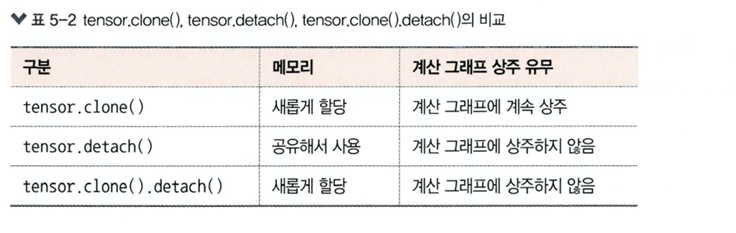


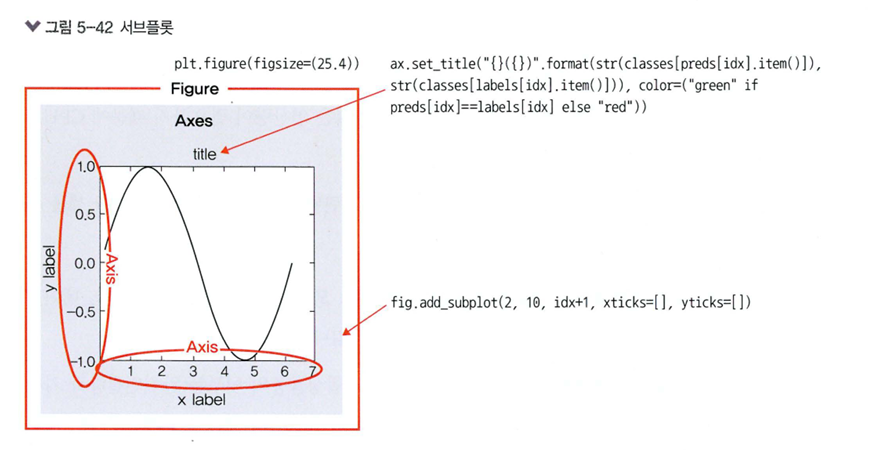

In [25]:
# 코드 28. 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

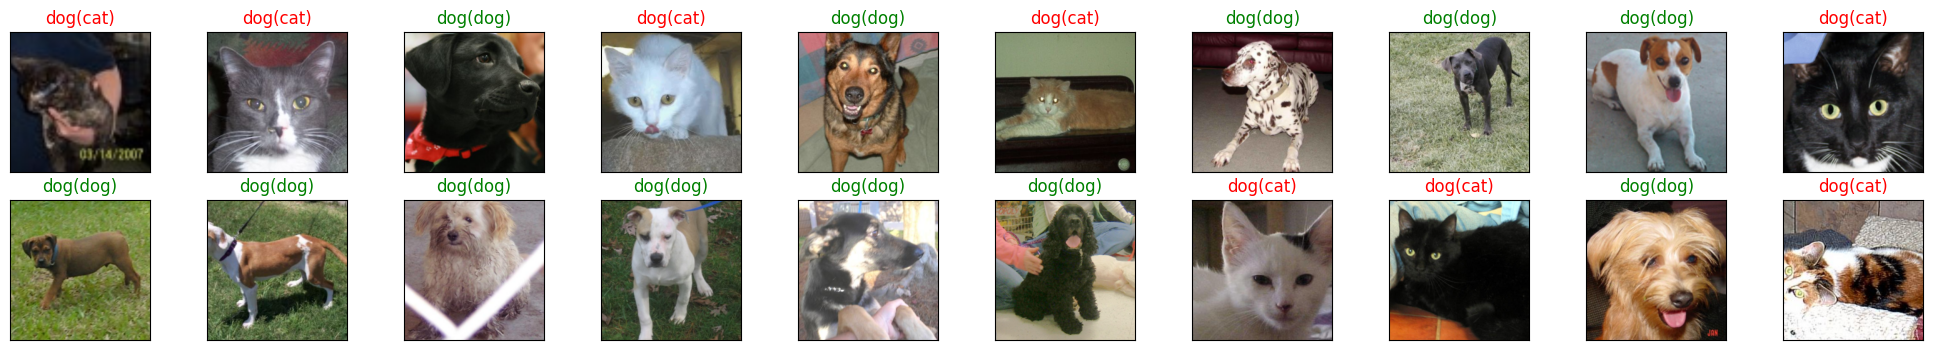

<Figure size 640x480 with 0 Axes>

In [26]:
# 코드 29. 개와 고양이 예측 결과 출
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels= next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

5.3.2 미세 조정 기법

- 미세 조정기법:  특성 추출기법에서 나아가 사전 훈련 모델과 함성곱층, 데이터 분류기의 가중치 업데이트해 훈련하는 방식.
  - 특성이 잘못 추출되었을 때 미세 조정기법으로 새로운 이미지 데이터를 사용해 네트워크의 가중치를 업데이트해 특성 재추출
  - 사전 학습 모델을 목적에 맞게 재학습/학습된 가중치의 일부를 재학습
  - 많은 연산량이 필요해 CPU보다 GPU사용 권장
  - 파라미터 업데이트할때 과적합 문제 발생할 수 있으므로 미세한 업데이트 필요
- ▶ 테이터셋이 크고 사전 훈련된 모델과 유사성이 작은경우: 모델 전체를 재학습
- ▶ 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분과 데이터 분류기를 학습. 데이셋이 유사라므로 강한 특징이 보이는 부분만 재학습
- ▶ 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분(적당히 설정)과 데이터 분류기를 학습
- ▶ 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우: 데이터 분류기만 학습. 과적합 우려


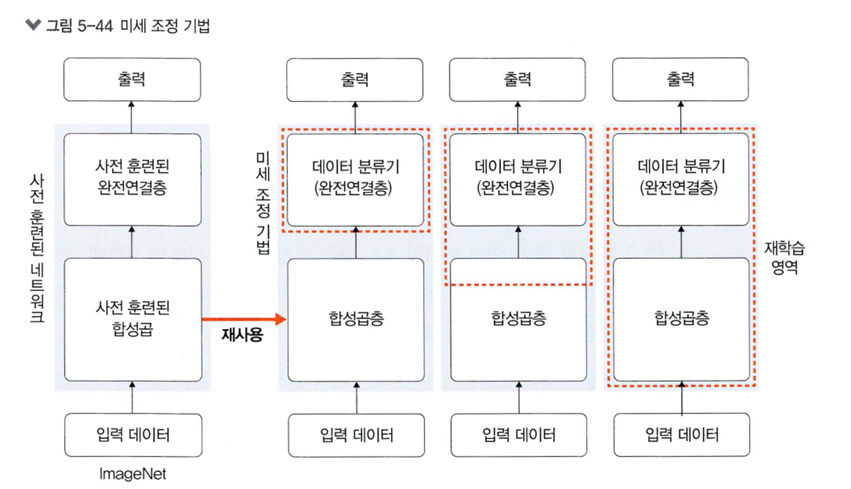
